In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

#Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torchvision
import numpy as np

import torch.nn as nn
from torch import optim

import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

from torch.autograd import Variable
import os



import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
%matplotlib inline
import time

In [2]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), transforms.Resize((48, 48)), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), transforms.Resize((48, 48)), tt.ToTensor()])

In [3]:
data_dir = './leapGestRecog'
print(os.listdir(data_dir))

['test', 'train']


In [4]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
test Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [5]:
digit_to_classname = {1:'palm', 2:'l', 3:'fist', 4:'fist_moved', 5:'thumb', 6:'index', 7:'ok', 8:'palm_moved', 9:'c', 10:'down'}

In [6]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [7]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 18000
    Root location: ./leapGestRecog/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(48, 48), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [8]:
torch.cuda.empty_cache()

In [9]:
batch_size = 250

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


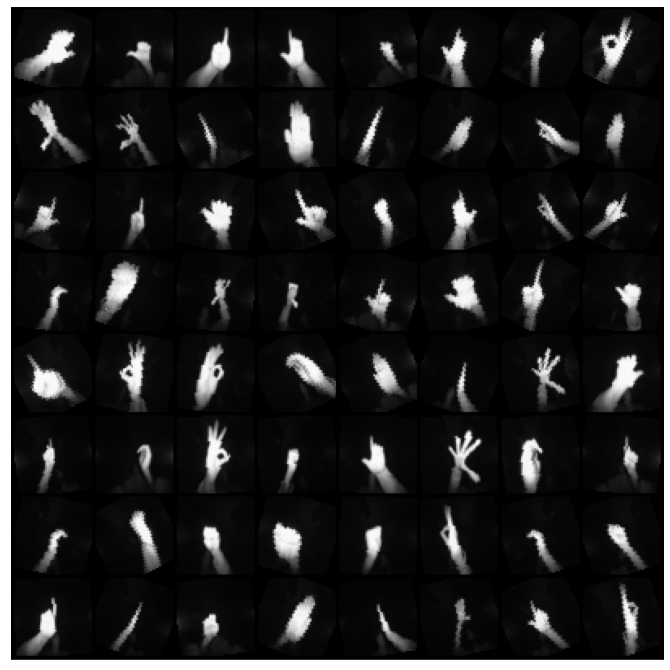

In [12]:
show_batch(train_dataloader)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [16]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [17]:
model = to_device(ResNet(1, len(classes_train)), device)

In [18]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [19]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [20]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 72 total_steps per epoch


In [21]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.6.0+cu101


In [68]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.347052476886246
Epoch 2, loss:  0.17880041059106588
Epoch 3, loss:  0.06451842851108974
Epoch 4, loss:  0.06129922627264427
Epoch 5, loss:  0.08817214785247213
Epoch 6, loss:  0.057030234615214996
Epoch 7, loss:  0.09191044000908732
Epoch 8, loss:  0.045131568036999345
Epoch 9, loss:  0.2571275162950365
Epoch 10, loss:  0.11122722847438934
Epoch 11, loss:  0.039631104402360506
Epoch 12, loss:  0.015333208907476446
Epoch 13, loss:  0.01885842658440298
Epoch 14, loss:  3.029963859182317
Epoch 15, loss:  0.35078395654757816
Epoch 16, loss:  0.11047163000330329
Epoch 17, loss:  0.06795674386537737
Epoch 18, loss:  0.04165408856028484
Epoch 19, loss:  0.03391522786114365
Epoch 20, loss:  0.03263211860192112
Epoch 21, loss:  0.024636723625008017
Epoch 22, loss:  0.0199116086651985
Epoch 23, loss:  0.02919335297257122
Epoch 24, loss:  0.02719970740791824
Epoch 25, loss:  0.025874796090647578
Epoch 26, loss:  0.013096149587201782
Epoch 27, loss:  0.01745328534161672
Epoch 28,

In [71]:
torch.save(model.state_dict(), './sign_detection_model_state_50_epoch.pth')

In [22]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./sign_detection_model_state_50_epoch.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

<ipython-input-23-2f79124c4a1c>:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)


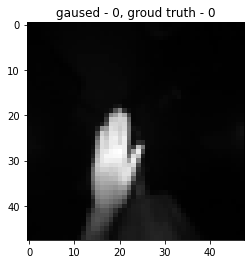

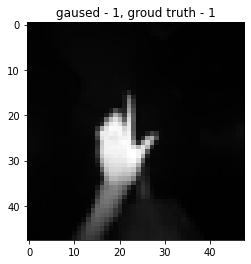

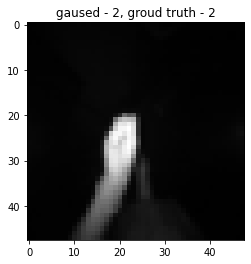

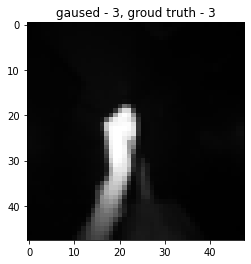

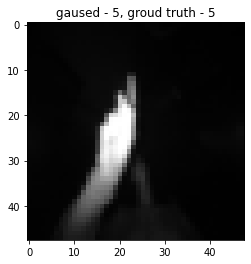

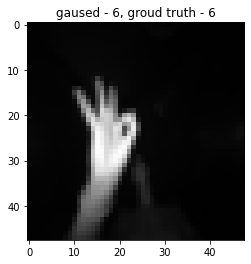

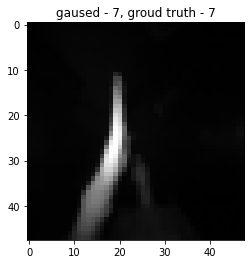

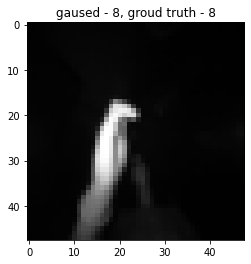

In [23]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

In [26]:
from models.faceboxes import FaceBoxes

def check_keys(model, pretrained_state_dict):
        ckpt_keys = set(pretrained_state_dict.keys())
        model_keys = set(model.state_dict().keys())
        used_pretrained_keys = model_keys & ckpt_keys
        unused_pretrained_keys = ckpt_keys - model_keys
        missing_keys = model_keys - ckpt_keys
        print('Missing keys:{}'.format(len(missing_keys)))
        print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
        print('Used keys:{}'.format(len(used_pretrained_keys)))
        assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
        return True

def remove_prefix(state_dict, prefix):
        ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
        print('remove prefix \'{}\''.format(prefix))
        f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
        return {f(key): value for key, value in state_dict.items()}

def load_model(model, pretrained_path='./weights/Final_HandBoxes.pth'):
        print('Loading pretrained model from {}'.format(pretrained_path))
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
        if "state_dict" in pretrained_dict.keys():
            pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
        else:
            pretrained_dict = remove_prefix(pretrained_dict, 'module.')
        check_keys(model, pretrained_dict)
        model.load_state_dict(pretrained_dict, strict=False)
        return model 

In [30]:
cap = cv2.VideoCapture(0)

class FaceDetector(object):
   
    
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = ResNet(1, len(classes_train)).to(self.device)
        self.emodel.load_state_dict(torch.load('./sign_detection_model_state_50_epoch.pth'))
        self.emodel.eval()
        self.im_model = FaceBoxes(phase='test', size=None, num_classes=2)
        self.im_model = load_model(self.im_model)
        self.im_model.eval()
        self.im_model = self.im_model.to(device)
   
    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 1:
            return 'palm'
        elif digit == 2:
            return 'l'
        elif digit == 3:
            return 'fist'
        elif digit == 4:
            return 'fist_moved'
        elif digit == 5:
            return 'thumb'
        elif digit == 6:
            return 'index'
        elif digit == 7:
            return 'ok'
        elif digit == 8:
            return 'palm_moved'
        elif digit == 9:
            return 'c'
        elif digit == 10:
            return 'down'
            
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()


            boxes, probs, landmarks = self.im_model(frame)
                
                # Вырезаем лицо из кадра
            face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
            face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
            torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
            emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
            emotion = self.digit_to_classname(emotion.argmax())

                # Рисуем на кадре
            self._draw(frame, boxes, probs, landmarks, emotion)



            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
# Создаем объект нашего класса приложения
fcd = FaceDetector()
# Запускаем
fcd.run()

Loading pretrained model from ./weights/Final_HandBoxes.pth
remove prefix 'module.'
Missing keys:27
Unused checkpoint keys:0
Used keys:147


TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input image channel, 6 output channels, 3x3 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2)    
        self.conv2 = nn.Conv2d(6, 12, 3) # input 6 inpput channels, 12 output channels, 5x5 square convolution kernel
        self.conv3 = nn.Conv2d(12, 24, 3) # input 12 inpput channels, 24 output channels, 5x5 square convolution kernel
        self.fc1 = nn.Linear(24 * 4 * 4, 192)
        self.fc2 = nn.Linear(192, 96)
        self.fc3 = nn.Linear(96, 48)
        self.fc4 = nn.Linear(48, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 24 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5,5), activation = 'relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))